In [15]:
import numpy as np
import os
import yaml
import argparse
import torch
from torch.nn.functional import mse_loss
from tqdm import trange

from src.patch_placement import place_patch

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'pulp-frontnet/PyTorch/')
from Frontnet.Frontnet import FrontnetModel

from src.util import load_dataset
model_path = 'pulp-frontnet/PyTorch/Models/Frontnet160x32.Q.pt'
model_config = '160x32'
dataset_path = 'pulp-frontnet/PyTorch/Data/160x96StrangersTestset.pickle'

device = torch.device('cpu')

In [2]:
#model = load_model(path=model_path, device=device, config=model_config)
#model.eval()
train_set = load_dataset(path=dataset_path, batch_size=32, shuffle=True, drop_last=False, num_workers=0)

In [3]:
import nemo
from Frontnet.Utils import ModelManager


model_params = FrontnetModel.configs[model_config]
w, h, c = model_params['w'], model_params['h'], model_params['c']

model = FrontnetModel(**model_params)

model = nemo.transform.quantize_pact(model, dummy_input=torch.ones((1, 1, h, w)).to("cpu"))
epoch, prec_dict = ModelManager.ReadQ(model_path, model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

In [4]:
image, gt = train_set.dataset.__getitem__(0)
image = image.unsqueeze(0)

In [5]:
pred = torch.cat(model(image)).squeeze(1)

In [6]:
plt.imshow(image[0][0].numpy(), cmap='gray')

In [7]:
print(pred)
print(gt)

mse = torch.nn.functional.mse_loss(pred, gt)
print(mse)

tensor([ 1.4889,  1.0100,  0.3417, -0.3669], grad_fn=<SqueezeBackward1>)
tensor([1.1624, 0.7180, 0.3299, 0.0713])
tensor(0.0960, grad_fn=<MseLossBackward0>)


In [23]:
# load optimized patch P and set of transformation matrices
patch = np.load('eval/exp1/hybrid5/patches.npy')[-1]
set_transforms = np.load('eval/exp1/hybrid5/positions_norm.npy')[:, -1]
targets = np.array([[1., -1., 0.], [1., 1., 0.]])

In [32]:
patch = torch.tensor(patch).unsqueeze(0).unsqueeze(0) * 255.
set_transforms = torch.tensor(set_transforms)

In [33]:
def get_transformation(sf, tx, ty):
    translation_vector = torch.stack([tx, ty]).unsqueeze(0)

    eye = torch.eye(2, 2).unsqueeze(0).to(sf.device)
    rotation_matrix = eye * sf

    transformation_matrix = torch.cat((rotation_matrix, translation_vector), dim=2)
    return transformation_matrix.float()

transformation_matrix = get_transformation(*set_transforms[:, 0, :])

In [34]:
transformation_matrix

tensor([[[0.5000, 0.0000, 0.5010],
         [0.0000, 0.5000, 0.4480]]])

In [35]:
mod_img = place_patch(image, patch, transformation_matrix)

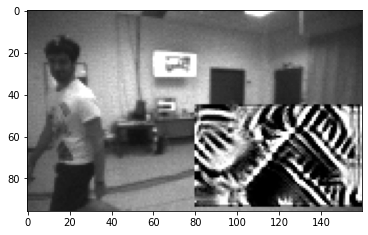

In [36]:
plt.imshow(mod_img[0][0].numpy(), cmap='gray')

In [17]:
pred_attack = torch.cat(model(mod_img)).squeeze(1)

In [18]:
print(pred_attack)
print(gt)

loss = torch.nn.functional.mse_loss(pred_attack, gt)
print(loss)

tensor([ 1.0786, -0.7284,  0.1184, -0.0299], grad_fn=<SqueezeBackward1>)
tensor([1.1624, 0.7180, 0.3299, 0.0713])
tensor(0.5386, grad_fn=<MseLossBackward0>)


In [30]:
# test on whole dataset
images, all_gt = train_set.dataset[:]
print(images.shape)

torch.Size([3625, 1, 96, 160])


In [21]:
predictions = torch.stack(model(images)).squeeze(2).mT

In [42]:
mse_gt = torch.nn.functional.mse_loss(predictions, all_gt)
mse_target = torch.nn.functional.mse_loss(predictions[..., :3], torch.tensor(targets[0]).repeat(len(predictions), 1))
print("MSE to ground truth: ", mse_gt)
print(f"MSE to {targets[0]}: ", mse_target)
mse_target = torch.nn.functional.mse_loss(predictions[..., :3], torch.tensor(targets[1]).repeat(len(predictions), 1))
print(f"MSE to {targets[1]}: ", mse_target)

MSE to ground truth:  tensor(0.1360, grad_fn=<MseLossBackward0>)
MSE to [ 1. -1.  0.]:  tensor(1.6207, dtype=torch.float64, grad_fn=<MseLossBackward0>)
MSE to [1. 1. 0.]:  tensor(0.6534, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [ ]:
# first target

In [37]:
mod_images = place_patch(images, patch, transformation_matrix)

In [38]:
predictions_mod = torch.stack(model(mod_images)).squeeze(2).mT

In [39]:
mod_mse_gt = torch.nn.functional.mse_loss(predictions_mod, all_gt)
mod_mse_target = torch.nn.functional.mse_loss(predictions_mod[..., :3], torch.tensor(targets[0]).repeat(len(predictions), 1))
print("MSE to ground truth: ", mod_mse_gt)
print(f"MSE to {targets[0]}: ", mod_mse_target)

MSE to ground truth:  tensor(1.0577, grad_fn=<MseLossBackward0>)
MSE to [ 1. -1.  0.]:  tensor(0.0308, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [ ]:
# second target

In [40]:
transformation_matrix_2 = get_transformation(*set_transforms[:, 1, :])
print(transformation_matrix_2)

tensor([[[ 0.5000,  0.0000, -0.7826],
         [ 0.0000,  0.5000,  0.4968]]])


In [43]:
mod_images = place_patch(images, patch, transformation_matrix_2)
predictions_mod = torch.stack(model(mod_images)).squeeze(2).mT
mod_mse_gt = torch.nn.functional.mse_loss(predictions_mod, all_gt)
mod_mse_target = torch.nn.functional.mse_loss(predictions_mod[..., :3], torch.tensor(targets[1]).repeat(len(predictions), 1))
print("MSE to ground truth: ", mod_mse_gt)
print(f"MSE to {targets[1]}: ", mod_mse_target)

MSE to ground truth:  tensor(0.7183, grad_fn=<MseLossBackward0>)
MSE to [1. 1. 0.]:  tensor(0.0363, dtype=torch.float64, grad_fn=<MseLossBackward0>)
